## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

train.csv - обучающий датасет<br>
test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

**1. Home Ownership** - домовладение

**2. Annual  Income** - годовой доход

**3. Years in current job** - количество лет на текущем месте работы

**4. Tax Liens** - налоговые обременения

**5. Number of Open Accounts** - количество открытых счетов

**6. Years of Credit History** - количество лет кредитной истории

**7. Maximum Open Credit** - наибольший открытый кредит

**8. Number of Credit Problems** - количество проблем с кредитом

**9. Months since last delinquent** - количество месяцев с последней просрочки платежа

**10. Bankruptcies** - банкротства

**11. Purpose** - цель кредита

**12. Term** - срок кредита

**13. Current Loan Amount** - текущая сумма кредита

**14. Current Credit Balance** - текущий кредитный баланс

**15. Monthly Debt** - ежемесячный долг

**16. Credit Score** - кредитный рейтинг

**17. Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings

warnings.simplefilter('ignore')
%matplotlib inline
cf.set_config_file(offline=True)

**Пути к директориям и файлам**

In [381]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

**Загрузка данных и оптимизация памяти**

In [382]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [383]:
def reduce_mem_usage(df):  
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [384]:
print(f'Количество строк и колонок: \ntrain:      {df_train.shape}')
print(f'test:       {df_test.shape}')

Количество строк и колонок: 
train:      (7500, 17)
test:       (2500, 16)


In [385]:
X = df_train.drop('Credit Default', axis=1)
y = df_train['Credit Default']

**Типы переменных**

In [386]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

**Обзор количественных признаков**

In [387]:
X.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000


**Обзор номинативных признаков**

**Посмотрим выбросы в данных

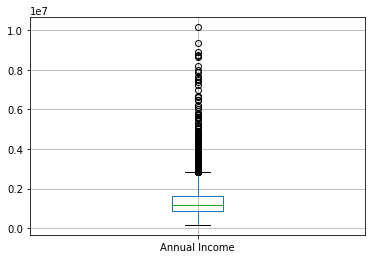

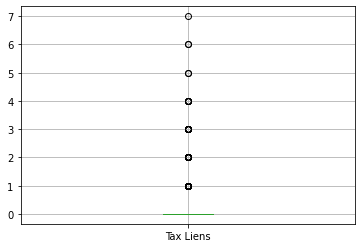

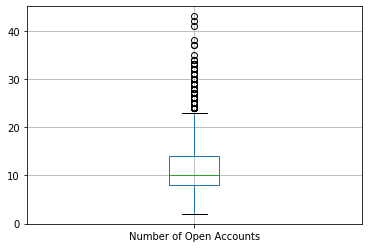

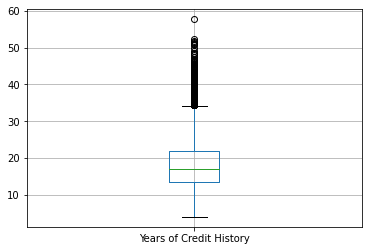

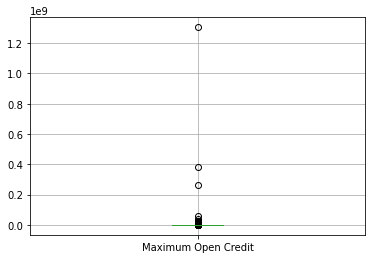

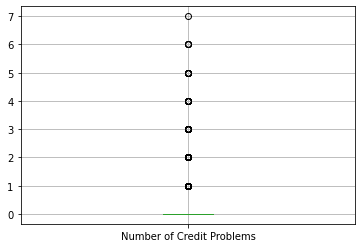

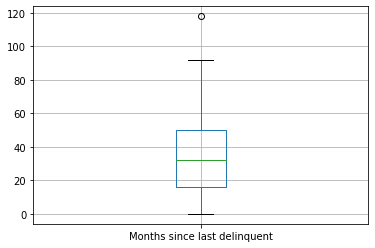

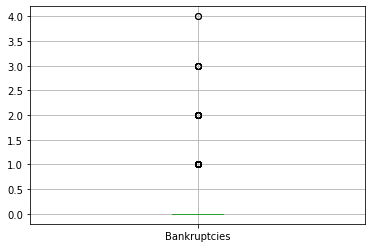

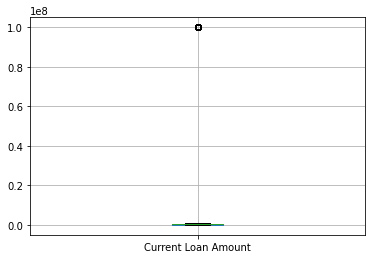

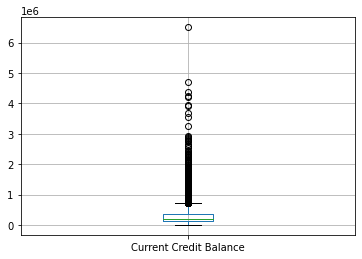

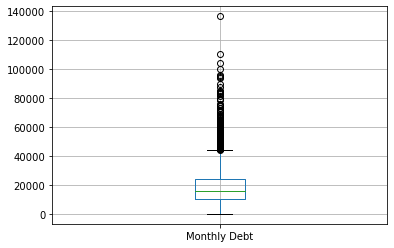

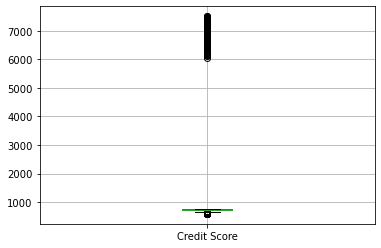

In [388]:
cols = X.select_dtypes(include='float32')
for col in cols:
    X.boxplot(column=[col])
    plt.show();

In [389]:
for cat_colname in X.select_dtypes(include='category').columns:
    print(f'{str(cat_colname)}  \n\n {str(X[cat_colname].value_counts())} \n{"-" * 100} \n')

Home Ownership  

 Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64 
---------------------------------------------------------------------------------------------------- 

Years in current job  

 10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64 
---------------------------------------------------------------------------------------------------- 

Purpose  

 debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      

**Обзор целевой переменной**

In [390]:
y_bar = (y.value_counts(normalize=True) * 100).round(2)
y_bar.iplot(kind='bar', barmode='stack', xTitle='Значения переменной',
            yTitle='проценты', title='Распределение целевой переменной')
print(f'Распределение целевой переменной: \n{y_bar} \n\nВсего значений: {y.shape[0]}')

Распределение целевой переменной: 
0    71.83
1    28.17
Name: Credit Default, dtype: float64 

Всего значений: 7500


### Обработка пропусков<a class="anchor" id="gaps"></a>

**Тепловая карта пропущенных значений поможет увидеть их распределение в данных**

<AxesSubplot:>

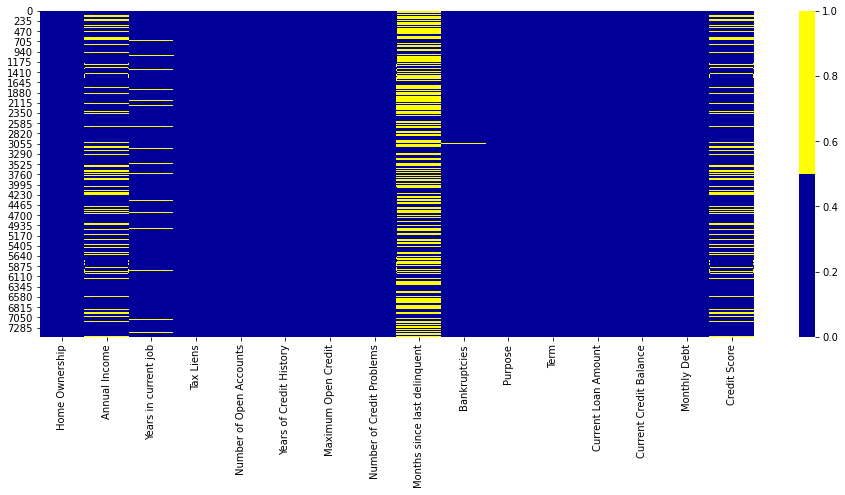

In [391]:
cols =X.columns
# определяем цвета: желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
plt.figure(figsize=(16,6))
sns.heatmap(X[cols].isnull(), cmap=sns.color_palette(colours))

**Количество пропусков по столбцам**

In [392]:
X.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
dtype: int64

**Annual Income, Months since last delinquent, Bankruptcies, Credit Score** заполним значением -888 и обработаем позже.

**Years in current job** пропуски заменим на 0, предположив, что человек только устроился на работу, поэтому графа не заполнена.



In [393]:
def replace_null(X):
    X.fillna({'Annual Income':-0.001,'Months since last delinquent':-0.001,
              'Bankruptcies':-0.001, 'Credit Score':-0.001}, inplace=True)
    X['Years in current job'].replace({np.nan:'0'}, inplace=True)
    X['Years in current job'] = X['Years in current job'].astype('category')
    return X

X = replace_null(X)
df_test = replace_null(df_test)

**Посмотрим на корреляцию количественных признаков.**

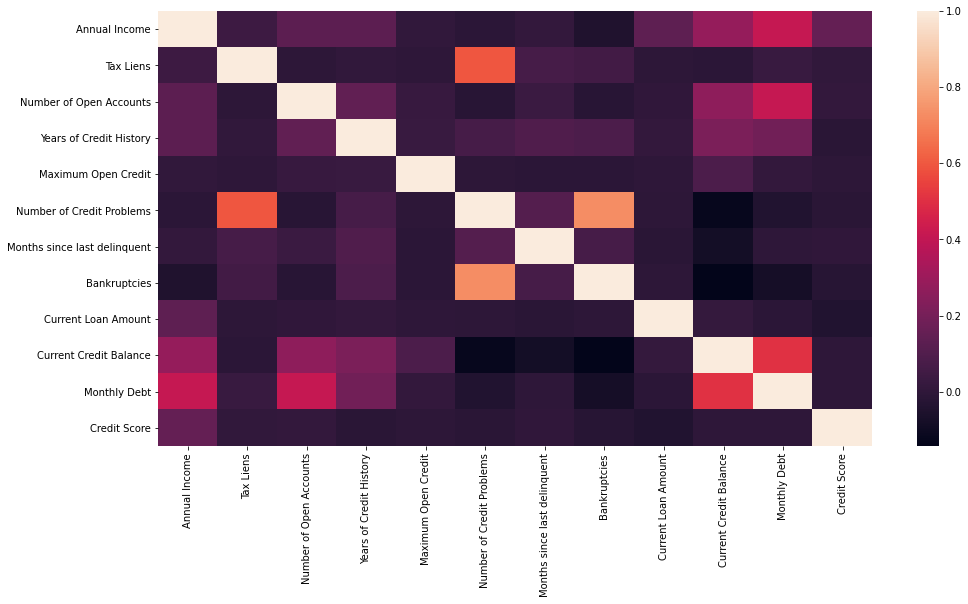

In [394]:
colums = X.select_dtypes(include='float64').columns
corr_matrix = X.drop(colums, axis=1).corr()

plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix);

In [395]:
X.select_dtypes(include='number')

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.000,0.0,11.0,26.299999,685960.0,1.0,-0.001,1.0,100000000.0,47386.0,7914.0,749.000
1,1025487.000,0.0,15.0,15.300000,1181730.0,0.0,-0.001,0.0,264968.0,394972.0,18373.0,737.000
2,751412.000,0.0,11.0,35.000000,1182434.0,0.0,-0.001,0.0,100000000.0,308389.0,13651.0,742.000
3,805068.000,0.0,8.0,22.500000,147400.0,1.0,-0.001,1.0,121396.0,95855.0,11338.0,694.000
4,776264.000,0.0,13.0,13.600000,385836.0,1.0,-0.001,0.0,125840.0,93309.0,7180.0,719.000
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.000,0.0,3.0,8.500000,107866.0,0.0,-0.001,0.0,129360.0,73492.0,1900.0,697.000
7496,1533984.000,0.0,10.0,26.500000,686312.0,0.0,43.000,0.0,444048.0,456399.0,12783.0,7410.000
7497,1878910.000,0.0,12.0,32.099998,1778920.0,0.0,-0.001,0.0,100000000.0,477812.0,12479.0,748.000
7498,-0.001,0.0,21.0,26.500000,1141250.0,0.0,-0.001,0.0,615274.0,476064.0,37118.0,-0.001


### Очистка данных<a class="anchor" id="gaps"></a>¶

In [396]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
        
    def fit(self, X):
        # расчет медианы для количественных переменных
        medians =  X.select_dtypes(include='number')
        self.medians = np.median(medians, axis=0)
        
        
    def transform(self, X):
        
        # в колонке "годовой доход" заполним пропуски медианой
        X.loc[(X['Annual Income'] == -0.001, 'Annual Income')] = self.medians[0]
        
        # в колонке "количество месяцев с последней просрочки платежа" заполним пропуски 0
        # предположив что в пропущеных значениях у людей нет просрочек
        X.loc[(X['Months since last delinquent'] == -0.001, 'Months since last delinquent')] = 0
        
        # в колонке "банкротства" заполним пропуски медианой
        X.loc[(X['Bankruptcies'] == -0.001, 'Bankruptcies')] = self.medians[7]
             
        # в колонке "кредитный рейтинг" заполним пропуски медианой
        X.loc[(X['Credit Score'] == -0.001, 'Credit Score')] = self.medians[11]
                 
            
            
        return X        

In [397]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_test = imputer.transform(df_test)

In [398]:
X.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,7500.000000,7500.000000,7500.0,7.500000e+03,7500.000000,7500.000000
mean,1.288081e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,15.815200,0.116933,11873135.0,2.898332e+05,18314.453125,1062.008911
std,7.678846e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,22.648802,0.346901,31926302.0,3.178713e+05,11926.758789,1438.783691
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,0.000000,0.000000,180169.0,1.142565e+05,10067.500000,718.000000
50%,9.892018e+05,0.000000,10.000000,17.000000,4.781590e+05,0.0000,0.000000,0.000000,309573.0,2.093230e+05,16076.500000,722.000000
75%,1.499974e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,29.000000,0.000000,519882.0,3.604062e+05,23818.000000,740.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000


In [399]:
categorical_features_indices = np.where((X.dtypes == 'category'))[0]
categorical_features_names = X.iloc[:, list(np.where(X.dtypes == 'category')[0])].columns

In [400]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.5, random_state=1111)
print(X_train.shape, X_valid.shape)

(3750, 16) (3750, 16)


In [401]:
class ClassifierObjective(object):
    def __init__(self, trainset, validset, const_params):
        self.train_dataset = trainset
        self.valid_dataset = validset
        self._const_params = const_params.copy()
        
    def _to_catboost_params(self, hyper_params):
        return {'iterations': int(hyper_params['iterations']),
                'learning_rate': hyper_params['learning_rate'],
                'depth': hyper_params['depth'],
                'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('\nEvaluating with params={}'.format(params))
        
        clf = CatBoostClassifier(**params)
        clf.fit(self.train_dataset, eval_set=self.valid_dataset, use_best_model=True)
        preds = clf.predict(self.valid_dataset)
        
        score = f1_score(self.valid_dataset.get_label(), preds)
        print('\nevaluated score={}'.format(score))
        
        return {'loss': 1-score, 'status': STATUS_OK}

In [402]:
def find_best_hyper_params(trainset, validset, const_params, max_evals=100):    
    parameter_space = {'iterations': hp.randint('iterations', 1500),
                       'learning_rate': hp.uniform('learning_rate', 0.2, 1.0),
                       'depth': hp.randint('depth', 15),
                       'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)}
    objective = ClassifierObjective(trainset, validset, const_params=const_params)
    trials = Trials()
    best = fmin(fn=objective, space=parameter_space, algo=tpe.suggest, max_evals=max_evals)
    return best


def train_best_model(X_tr, y_tr, X_val, y_val, X_all, y_all, const_params, cat_features, max_evals=100):
    trainset = Pool(X_tr, y_tr, cat_features=cat_features)
    validset = Pool(X_val, y_val, cat_features=cat_features)
    dataset = Pool(X_all, y_all, cat_features=cat_features)
    
    best = find_best_hyper_params(trainset, validset, const_params, max_evals=max_evals)
  
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    model = CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [403]:
'''weight = train_df['Credit Default'].value_counts()[0] / X['Credit Default'].value_counts()[1]
const_params = dict({'task_type': 'CPU',
                    'loss_function': 'Logloss',
                    'eval_metric': 'F1', 
                    'custom_metric': ['F1'],
                    'class_weights': [1, weight],
                    'verbose': 200})'''

"weight = train_df['Credit Default'].value_counts()[0] / X['Credit Default'].value_counts()[1]\nconst_params = dict({'task_type': 'CPU',\n                    'loss_function': 'Logloss',\n                    'eval_metric': 'F1', \n                    'custom_metric': ['F1'],\n                    'class_weights': [1, weight],\n                    'verbose': 200})"

In [404]:
const_params = dict({'depth': 5, 'iterations': 1012, 'l2_leaf_reg': 2.3434453561481288,
                 'learning_rate': 0.32871882500026756, 'task_type': 'CPU',
                 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['F1'],
                 'class_weights': [1, 2.549455750118315], 'verbose': 200})

In [405]:
model, params = train_best_model(X_train, y_train, X_valid, y_valid, X, y,
                                 const_params, categorical_features_indices, max_evals=1)
print(f'best params are {params}')

                                                     
Evaluating with params={'iterations': 1012, 'learning_rate': 0.32871882500026756, 'depth': 5, 'l2_leaf_reg': 2.3434453561481288, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['F1'], 'class_weights': [1, 2.549455750118315], 'verbose': 200}
0:	learn: 0.5979455	test: 0.6014208	best: 0.6014208 (0)	total: 10.3ms	remaining: 10.4s

200:	learn: 0.9708302	test: 0.5911447	best: 0.6626465 (7)	total: 936ms	remaining: 3.78s

400:	learn: 0.9983454	test: 0.5635359	best: 0.6626465 (7)	total: 1.93s	remaining: 2.94s

600:	learn: 1.0000000	test: 0.5554235	best: 0.6626465 (7)	total: 2.82s	remaining: 1.93s

800:	learn: 1.0000000	test: 0.5451354	best: 0.6626465 (7)	total: 3.68s	remaining: 969ms

1000:	learn: 1.0000000	test: 0.5454175	best: 0.6626465 (7)	total: 4.54s	remaining: 49.9ms

1011:	learn: 1.0000000	test: 0.5458033	best: 0.6626465 (7)	total: 4.61s	remaining: 0us

bestTest = 0.6626465358                    

<BarContainer object of 16 artists>

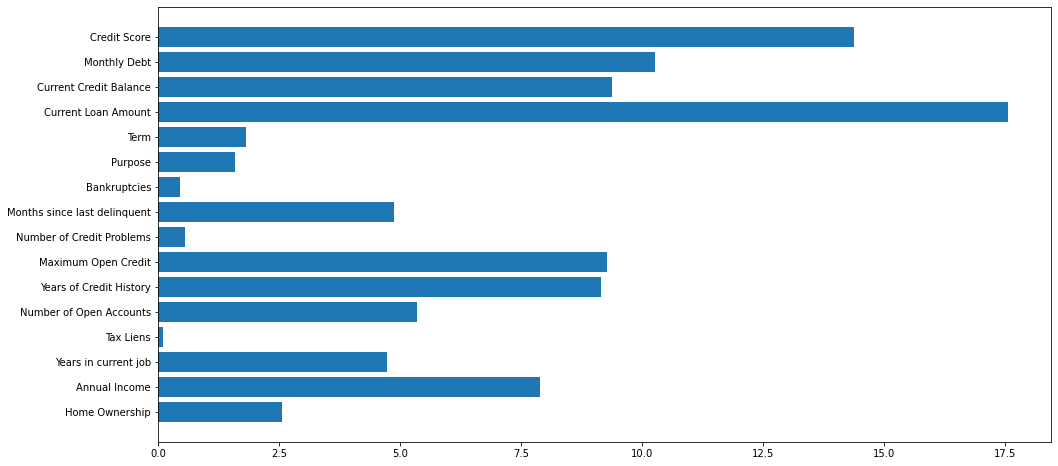

In [406]:
plt.figure(figsize=(16,8))
plt.barh(X.columns, model.get_feature_importance())

In [407]:
preds = model.predict(X)
f1_sc = f1_score(y, preds)
p_score = precision_score(y, preds)
r_score = recall_score(y, preds)
print(f'F1-score: {round(f1_sc,2)}\nWith precision = {round(p_score,2)} and recall = {round(r_score,2)}')

F1-score: 1.0
With precision = 0.99 and recall = 1.0


In [408]:
final_preds = model.predict(X_test)

predicted_df = pd.DataFrame(final_preds, columns=['Credit Default'])
predicted_df.to_csv('Maiun_Artem_predictions.csv', index_label='id')

predicted_df.shape

(2500, 1)

In [409]:
model.save_model('catboost_info/model.py', format='python', pool=X)